#### This is the experiment and graph code of OthelloGPT using SAE.

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# Imports
import torch
import matplotlib.pyplot as plt
from utils.dataloaders import get_dataloader
import utils.dataloaders
from tqdm import tqdm
from utils.game_engine import history_to_legal_moves
import utils.game_engine
from torcheval.metrics import BinaryAUROC
import pickle as pkl
import os
import sys
import numpy as np
import seaborn as sns
import analysis
from neel_plotly import line, scatter, imshow, histogram


c:\Users\ALTjasonspeed\.conda\envs\othellogpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ALTjasonspeed\.conda\envs\othellogpt\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [6]:
# GPU acceleration
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
class Tee:
    def __init__(self, filepath):
        self.file = open(filepath, "w")
        self.stdout = sys.stdout

    def write(self, message):
        self.file.write(message)
        self.stdout.write(message)

    def flush(self):
        self.file.flush()
        self.stdout.flush()

    def close(self):
        self.file.close()


# tee = Tee("output.log")
# sys.stdout = tee
# ...
# sys.stdout = sys.__stdout__
# tee.close()

#### Train linear_probe on all layers

In [15]:
from model_training import full_probe_run

tee = Tee("output.log")
sys.stdout = tee

layers = list(range(0, 8))
for layer in layers:
    full_probe_run(layer)

sys.stdout = sys.__stdout__
tee.close()

Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 100 steps.


  6%|▋         | 101/1563 [00:08<07:54,  3.08it/s]

Train loss and test accuracy after 100 steps: 0.7729, 62.0000%


 13%|█▎        | 201/1563 [00:16<07:36,  2.99it/s]

Train loss and test accuracy after 200 steps: 0.7655, 61.9790%


 19%|█▉        | 301/1563 [00:24<07:09,  2.94it/s]

Train loss and test accuracy after 300 steps: 0.7689, 62.0044%


 26%|██▌       | 401/1563 [00:33<06:36,  2.93it/s]

Train loss and test accuracy after 400 steps: 0.7655, 62.0121%


 32%|███▏      | 501/1563 [00:41<05:50,  3.03it/s]

Train loss and test accuracy after 500 steps: 0.7615, 62.0016%


 38%|███▊      | 601/1563 [00:49<05:17,  3.03it/s]

Train loss and test accuracy after 600 steps: 0.7607, 61.9762%


 45%|████▍     | 701/1563 [00:57<04:44,  3.03it/s]

Train loss and test accuracy after 700 steps: 0.7710, 62.0181%


 51%|█████     | 801/1563 [01:05<04:13,  3.00it/s]

Train loss and test accuracy after 800 steps: 0.7621, 62.0416%


 58%|█████▊    | 901/1563 [01:13<03:33,  3.11it/s]

Train loss and test accuracy after 900 steps: 0.7629, 62.0688%


 64%|██████▍   | 1001/1563 [01:21<03:06,  3.02it/s]

Train loss and test accuracy after 1000 steps: 0.7588, 62.0635%


 70%|███████   | 1101/1563 [01:29<02:30,  3.08it/s]

Train loss and test accuracy after 1100 steps: 0.7594, 62.0354%


 77%|███████▋  | 1201/1563 [01:38<01:59,  3.03it/s]

Train loss and test accuracy after 1200 steps: 0.7635, 62.0574%


 83%|████████▎ | 1301/1563 [01:46<01:24,  3.09it/s]

Train loss and test accuracy after 1300 steps: 0.7605, 62.0772%


 90%|████████▉ | 1401/1563 [01:54<00:55,  2.90it/s]

Train loss and test accuracy after 1400 steps: 0.7563, 62.0938%


 96%|█████████▌| 1501/1563 [02:02<00:21,  2.94it/s]

Train loss and test accuracy after 1500 steps: 0.7627, 62.0970%


100%|██████████| 1563/1563 [02:06<00:00, 12.34it/s]


Train loss and test accuracy after Omega steps: 0.7553, 62.1308%
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 100 steps.


  7%|▋         | 102/1563 [00:11<10:24,  2.34it/s]

Train loss and test accuracy after 100 steps: 0.5801, 73.8602%


 13%|█▎        | 201/1563 [00:22<13:16,  1.71it/s]

Train loss and test accuracy after 200 steps: 0.5142, 76.5684%


 19%|█▉        | 301/1563 [00:33<11:48,  1.78it/s]

Train loss and test accuracy after 300 steps: 0.4882, 77.4759%


 26%|██▌       | 401/1563 [00:43<10:27,  1.85it/s]

Train loss and test accuracy after 400 steps: 0.4728, 77.9136%


 32%|███▏      | 501/1563 [00:54<09:32,  1.86it/s]

Train loss and test accuracy after 500 steps: 0.4639, 78.1567%


 39%|███▊      | 603/1563 [01:05<06:38,  2.41it/s]

Train loss and test accuracy after 600 steps: 0.4572, 78.3046%


 45%|████▍     | 703/1563 [01:16<05:39,  2.54it/s]

Train loss and test accuracy after 700 steps: 0.4618, 78.3909%


 51%|█████     | 801/1563 [01:27<06:55,  1.83it/s]

Train loss and test accuracy after 800 steps: 0.4545, 78.4765%


 58%|█████▊    | 901/1563 [01:38<06:29,  1.70it/s]

Train loss and test accuracy after 900 steps: 0.4456, 78.5472%


 64%|██████▍   | 1002/1563 [01:49<04:42,  1.99it/s]

Train loss and test accuracy after 1000 steps: 0.4482, 78.5598%


 71%|███████   | 1102/1563 [02:00<03:24,  2.26it/s]

Train loss and test accuracy after 1100 steps: 0.4488, 78.6263%


 77%|███████▋  | 1202/1563 [02:11<02:38,  2.28it/s]

Train loss and test accuracy after 1200 steps: 0.4444, 78.6252%


 83%|████████▎ | 1302/1563 [02:22<01:57,  2.22it/s]

Train loss and test accuracy after 1300 steps: 0.4491, 78.6242%


 90%|████████▉ | 1402/1563 [02:33<01:08,  2.35it/s]

Train loss and test accuracy after 1400 steps: 0.4422, 78.6455%


 96%|█████████▌| 1502/1563 [02:44<00:30,  2.01it/s]

Train loss and test accuracy after 1500 steps: 0.4462, 78.6620%


100%|██████████| 1563/1563 [02:48<00:00,  9.27it/s]


Train loss and test accuracy after Omega steps: 0.4491, 78.6898%
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 100 steps.


  6%|▋         | 100/1563 [00:13<18:11,  1.34it/s]

Train loss and test accuracy after 100 steps: 0.4258, 82.1919%


 13%|█▎        | 201/1563 [00:25<15:54,  1.43it/s]

Train loss and test accuracy after 200 steps: 0.3567, 84.2911%


 19%|█▉        | 301/1563 [00:39<16:01,  1.31it/s]

Train loss and test accuracy after 300 steps: 0.3287, 84.9357%


 26%|██▌       | 401/1563 [00:52<15:28,  1.25it/s]

Train loss and test accuracy after 400 steps: 0.3169, 85.2457%


 32%|███▏      | 501/1563 [01:05<12:55,  1.37it/s]

Train loss and test accuracy after 500 steps: 0.3084, 85.4256%


 38%|███▊      | 600/1563 [01:19<12:45,  1.26it/s]

Train loss and test accuracy after 600 steps: 0.3044, 85.5144%


 45%|████▍     | 701/1563 [01:32<12:01,  1.19it/s]

Train loss and test accuracy after 700 steps: 0.3071, 85.5966%


 51%|█████▏    | 802/1563 [01:45<07:07,  1.78it/s]

Train loss and test accuracy after 800 steps: 0.3004, 85.6431%


 58%|█████▊    | 902/1563 [01:58<05:47,  1.90it/s]

Train loss and test accuracy after 900 steps: 0.2951, 85.7179%


 64%|██████▍   | 1001/1563 [02:12<06:08,  1.53it/s]

Train loss and test accuracy after 1000 steps: 0.2947, 85.7468%


 71%|███████   | 1102/1563 [02:25<04:23,  1.75it/s]

Train loss and test accuracy after 1100 steps: 0.2926, 85.7682%


 77%|███████▋  | 1202/1563 [02:38<03:18,  1.82it/s]

Train loss and test accuracy after 1200 steps: 0.2927, 85.7656%


 83%|████████▎ | 1301/1563 [02:51<03:28,  1.26it/s]

Train loss and test accuracy after 1300 steps: 0.2972, 85.7755%


 90%|████████▉ | 1400/1563 [03:05<02:19,  1.16it/s]

Train loss and test accuracy after 1400 steps: 0.2897, 85.7948%


 96%|█████████▌| 1502/1563 [03:19<00:36,  1.68it/s]

Train loss and test accuracy after 1500 steps: 0.2931, 85.7854%


100%|██████████| 1563/1563 [03:24<00:00,  7.64it/s]


Train loss and test accuracy after Omega steps: 0.2952, 85.7912%
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 100 steps.


  7%|▋         | 102/1563 [00:16<19:53,  1.22it/s]

Train loss and test accuracy after 100 steps: 0.3588, 85.7446%


 13%|█▎        | 202/1563 [00:31<23:12,  1.02s/it]

Train loss and test accuracy after 200 steps: 0.2952, 87.3657%


 19%|█▉        | 301/1563 [00:47<25:05,  1.19s/it]

Train loss and test accuracy after 300 steps: 0.2696, 87.8741%


 26%|██▌       | 402/1563 [01:03<18:00,  1.07it/s]

Train loss and test accuracy after 400 steps: 0.2613, 88.0779%


 32%|███▏      | 502/1563 [01:19<17:12,  1.03it/s]

Train loss and test accuracy after 500 steps: 0.2542, 88.1846%


 38%|███▊      | 601/1563 [01:35<14:30,  1.10it/s]

Train loss and test accuracy after 600 steps: 0.2531, 88.2684%


 45%|████▍     | 702/1563 [01:51<11:55,  1.20it/s]

Train loss and test accuracy after 700 steps: 0.2529, 88.3014%


 51%|█████▏    | 802/1563 [02:07<09:25,  1.35it/s]

Train loss and test accuracy after 800 steps: 0.2483, 88.3537%


 58%|█████▊    | 902/1563 [02:22<08:48,  1.25it/s]

Train loss and test accuracy after 900 steps: 0.2432, 88.4018%


 64%|██████▍   | 1001/1563 [02:38<09:42,  1.04s/it]

Train loss and test accuracy after 1000 steps: 0.2428, 88.4057%


 70%|███████   | 1101/1563 [02:53<07:21,  1.05it/s]

Train loss and test accuracy after 1100 steps: 0.2400, 88.4318%


 77%|███████▋  | 1201/1563 [03:08<05:27,  1.10it/s]

Train loss and test accuracy after 1200 steps: 0.2439, 88.4132%


 83%|████████▎ | 1301/1563 [03:24<05:34,  1.28s/it]

Train loss and test accuracy after 1300 steps: 0.2477, 88.4542%


 90%|████████▉ | 1402/1563 [03:40<02:17,  1.17it/s]

Train loss and test accuracy after 1400 steps: 0.2386, 88.4658%


 96%|█████████▌| 1501/1563 [03:55<01:01,  1.00it/s]

Train loss and test accuracy after 1500 steps: 0.2456, 88.4693%


100%|██████████| 1563/1563 [04:01<00:00,  6.47it/s]


Train loss and test accuracy after Omega steps: 0.2477, 88.4749%
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 100 steps.


  6%|▋         | 101/1563 [00:18<37:35,  1.54s/it]

Train loss and test accuracy after 100 steps: 0.3272, 87.2857%


 13%|█▎        | 202/1563 [00:35<27:57,  1.23s/it]

Train loss and test accuracy after 200 steps: 0.2668, 88.7226%


 19%|█▉        | 300/1563 [00:53<49:35,  2.36s/it]

Train loss and test accuracy after 300 steps: 0.2445, 89.1789%


 26%|██▌       | 400/1563 [01:11<38:05,  1.96s/it]

Train loss and test accuracy after 400 steps: 0.2384, 89.3729%


 32%|███▏      | 500/1563 [01:29<31:44,  1.79s/it]

Train loss and test accuracy after 500 steps: 0.2327, 89.4413%


 38%|███▊      | 600/1563 [01:47<37:05,  2.31s/it]

Train loss and test accuracy after 600 steps: 0.2296, 89.5430%


 45%|████▍     | 701/1563 [02:06<23:45,  1.65s/it]

Train loss and test accuracy after 700 steps: 0.2298, 89.5716%


 51%|█████▏    | 802/1563 [02:23<14:00,  1.11s/it]

Train loss and test accuracy after 800 steps: 0.2249, 89.6101%


 58%|█████▊    | 902/1563 [02:41<12:49,  1.16s/it]

Train loss and test accuracy after 900 steps: 0.2196, 89.6339%


 64%|██████▍   | 1000/1563 [02:59<21:30,  2.29s/it]

Train loss and test accuracy after 1000 steps: 0.2217, 89.6637%


 70%|███████   | 1101/1563 [03:17<11:39,  1.51s/it]

Train loss and test accuracy after 1100 steps: 0.2163, 89.6542%


 77%|███████▋  | 1201/1563 [03:35<09:05,  1.51s/it]

Train loss and test accuracy after 1200 steps: 0.2197, 89.6914%


 83%|████████▎ | 1302/1563 [03:53<05:00,  1.15s/it]

Train loss and test accuracy after 1300 steps: 0.2249, 89.7033%


 90%|████████▉ | 1401/1563 [04:11<04:05,  1.51s/it]

Train loss and test accuracy after 1400 steps: 0.2147, 89.7099%


 96%|█████████▌| 1500/1563 [04:28<01:55,  1.83s/it]

Train loss and test accuracy after 1500 steps: 0.2248, 89.7124%


100%|██████████| 1563/1563 [04:35<00:00,  5.67it/s]


Train loss and test accuracy after Omega steps: 0.2240, 89.7207%
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 100 steps.


  6%|▋         | 101/1563 [00:19<43:23,  1.78s/it]

Train loss and test accuracy after 100 steps: 0.3205, 87.5650%


 13%|█▎        | 201/1563 [00:38<40:47,  1.80s/it]

Train loss and test accuracy after 200 steps: 0.2593, 89.0646%


 19%|█▉        | 301/1563 [00:58<39:19,  1.87s/it]

Train loss and test accuracy after 300 steps: 0.2398, 89.5638%


 26%|██▌       | 401/1563 [01:18<37:18,  1.93s/it]

Train loss and test accuracy after 400 steps: 0.2322, 89.7915%


 32%|███▏      | 501/1563 [01:38<33:41,  1.90s/it]

Train loss and test accuracy after 500 steps: 0.2250, 89.9256%


 38%|███▊      | 601/1563 [01:58<30:44,  1.92s/it]

Train loss and test accuracy after 600 steps: 0.2239, 89.9891%


 45%|████▍     | 701/1563 [02:18<25:52,  1.80s/it]

Train loss and test accuracy after 700 steps: 0.2230, 90.0367%


 51%|█████     | 801/1563 [02:37<23:26,  1.85s/it]

Train loss and test accuracy after 800 steps: 0.2181, 90.0908%


 58%|█████▊    | 901/1563 [02:57<20:36,  1.87s/it]

Train loss and test accuracy after 900 steps: 0.2146, 90.1207%


 64%|██████▍   | 1001/1563 [03:17<17:28,  1.87s/it]

Train loss and test accuracy after 1000 steps: 0.2122, 90.1575%


 70%|███████   | 1101/1563 [03:36<14:05,  1.83s/it]

Train loss and test accuracy after 1100 steps: 0.2102, 90.1478%


 77%|███████▋  | 1201/1563 [03:56<11:10,  1.85s/it]

Train loss and test accuracy after 1200 steps: 0.2145, 90.1385%


 83%|████████▎ | 1301/1563 [04:16<08:10,  1.87s/it]

Train loss and test accuracy after 1300 steps: 0.2161, 90.1915%


 90%|████████▉ | 1401/1563 [04:36<04:49,  1.79s/it]

Train loss and test accuracy after 1400 steps: 0.2095, 90.1899%


 96%|█████████▌| 1501/1563 [04:55<01:48,  1.75s/it]

Train loss and test accuracy after 1500 steps: 0.2152, 90.1871%


100%|██████████| 1563/1563 [05:02<00:00,  5.17it/s]


Train loss and test accuracy after Omega steps: 0.2158, 90.2147%
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 100 steps.


  6%|▋         | 101/1563 [00:22<52:52,  2.17s/it]  

Train loss and test accuracy after 100 steps: 0.3286, 87.4249%


 13%|█▎        | 201/1563 [00:43<45:54,  2.02s/it]  

Train loss and test accuracy after 200 steps: 0.2656, 89.0004%


 19%|█▉        | 301/1563 [01:04<41:53,  1.99s/it]

Train loss and test accuracy after 300 steps: 0.2452, 89.5892%


 26%|██▌       | 401/1563 [01:26<42:18,  2.18s/it]

Train loss and test accuracy after 400 steps: 0.2359, 89.8705%


 32%|███▏      | 501/1563 [01:48<39:07,  2.21s/it]

Train loss and test accuracy after 500 steps: 0.2278, 90.0171%


 38%|███▊      | 600/1563 [02:10<47:53,  2.98s/it]

Train loss and test accuracy after 600 steps: 0.2262, 90.1267%


 45%|████▍     | 701/1563 [02:32<31:29,  2.19s/it]

Train loss and test accuracy after 700 steps: 0.2264, 90.1901%


 51%|█████     | 801/1563 [02:54<27:01,  2.13s/it]

Train loss and test accuracy after 800 steps: 0.2205, 90.1951%


 58%|█████▊    | 901/1563 [03:16<22:35,  2.05s/it]

Train loss and test accuracy after 900 steps: 0.2147, 90.2725%


 64%|██████▍   | 1001/1563 [03:37<19:33,  2.09s/it]

Train loss and test accuracy after 1000 steps: 0.2146, 90.3060%


 70%|███████   | 1101/1563 [03:59<15:32,  2.02s/it]

Train loss and test accuracy after 1100 steps: 0.2094, 90.2939%


 77%|███████▋  | 1200/1563 [04:20<17:51,  2.95s/it]

Train loss and test accuracy after 1200 steps: 0.2157, 90.3281%


 83%|████████▎ | 1301/1563 [04:42<09:29,  2.17s/it]

Train loss and test accuracy after 1300 steps: 0.2190, 90.3419%


 90%|████████▉ | 1401/1563 [05:04<05:46,  2.14s/it]

Train loss and test accuracy after 1400 steps: 0.2094, 90.3525%


 96%|█████████▌| 1501/1563 [05:26<02:10,  2.11s/it]

Train loss and test accuracy after 1500 steps: 0.2141, 90.3638%


100%|██████████| 1563/1563 [05:34<00:00,  4.68it/s]


Train loss and test accuracy after Omega steps: 0.2176, 90.3796%
Beginning model training on cuda!
Beginning epoch 1/1. Epoch duration is 1563 steps, will evaluate every 100 steps.


  6%|▋         | 101/1563 [00:24<57:40,  2.37s/it]  

Train loss and test accuracy after 100 steps: 0.3373, 87.2570%


 13%|█▎        | 201/1563 [00:48<54:59,  2.42s/it]  

Train loss and test accuracy after 200 steps: 0.2693, 88.9184%


 19%|█▉        | 301/1563 [01:12<51:17,  2.44s/it]  

Train loss and test accuracy after 300 steps: 0.2497, 89.4998%


 26%|██▌       | 401/1563 [01:37<49:57,  2.58s/it]  

Train loss and test accuracy after 400 steps: 0.2391, 89.8267%


 32%|███▏      | 501/1563 [02:02<44:09,  2.49s/it]  

Train loss and test accuracy after 500 steps: 0.2303, 89.9867%


 38%|███▊      | 601/1563 [02:27<38:58,  2.43s/it]

Train loss and test accuracy after 600 steps: 0.2299, 90.0970%


 45%|████▍     | 701/1563 [02:50<31:58,  2.23s/it]

Train loss and test accuracy after 700 steps: 0.2291, 90.1585%


 51%|█████     | 801/1563 [03:14<29:58,  2.36s/it]

Train loss and test accuracy after 800 steps: 0.2216, 90.2027%


 58%|█████▊    | 901/1563 [03:38<26:53,  2.44s/it]

Train loss and test accuracy after 900 steps: 0.2164, 90.2627%


 64%|██████▍   | 1001/1563 [04:03<23:39,  2.53s/it]

Train loss and test accuracy after 1000 steps: 0.2188, 90.2771%


 70%|███████   | 1101/1563 [04:27<18:35,  2.41s/it]

Train loss and test accuracy after 1100 steps: 0.2128, 90.3105%


 77%|███████▋  | 1201/1563 [04:52<14:27,  2.40s/it]

Train loss and test accuracy after 1200 steps: 0.2178, 90.3291%


 83%|████████▎ | 1301/1563 [05:16<10:12,  2.34s/it]

Train loss and test accuracy after 1300 steps: 0.2220, 90.3291%


 90%|████████▉ | 1401/1563 [05:39<06:06,  2.26s/it]

Train loss and test accuracy after 1400 steps: 0.2136, 90.3342%


 96%|█████████▌| 1501/1563 [06:04<02:27,  2.38s/it]

Train loss and test accuracy after 1500 steps: 0.2178, 90.3565%


100%|██████████| 1563/1563 [06:12<00:00,  4.20it/s]


Train loss and test accuracy after Omega steps: 0.2189, 90.3661%


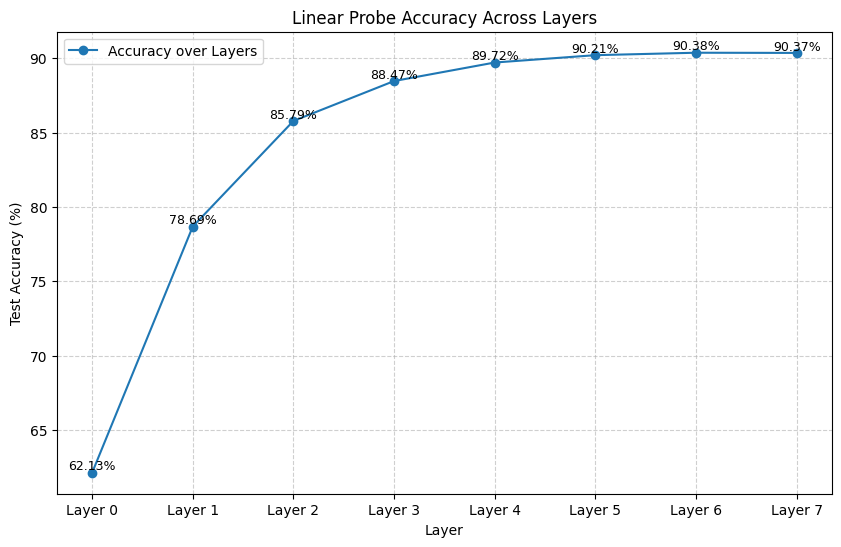

In [4]:
# Plot probe training acc
import re

log_file_path = "probe_train_output.log"
layer_pattern = re.compile(r"Train loss and test accuracy after Omega steps: .*?, (\d+\.\d+)%")
with open(log_file_path, 'r') as f:
    log_content = f.read()
accuracies = [float(match) for match in layer_pattern.findall(log_content)]
layers = list(range(len(accuracies)))

plt.figure(figsize=(10, 6))
plt.plot(layers, accuracies, marker='o', linestyle='-', label="Accuracy over Layers")
# Annotate each point with its accuracy value
for i, acc in enumerate(accuracies):
    plt.text(layers[i], acc, f"{acc:.2f}%", fontsize=9, ha='center', va='bottom')
plt.title("Linear Probe Accuracy Across Layers")
plt.xlabel("Layer")
plt.ylabel("Test Accuracy (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(len(layers)), [f"Layer {i}" for i in layers])
plt.legend()
plt.show()

In [7]:
model_location = "trained_model_full.pkl"
with open(model_location, 'rb') as f:
    othello_gpt=torch.load(f, map_location=device)

In [10]:
layers = list(range(0,8))
mode = 2 # ["empty", "own", "enemy"]

for layer in layers:
    # Probe
    probe_path = f"probes/probe_layer_{layer}.pkl"
    full_linear_probe = torch.load(probe_path)
    my_probe_W = full_linear_probe.state_dict()[f'classifier.{mode}.weight'] # (64, 512)
    my_probe_W = my_probe_W.t()
    my_probe_normalised = my_probe_W / my_probe_W.norm(dim=0, keepdim=True) # torch.Size([512, 64])
    my_probe_normalised[:, [27, 28, 35, 36]] = 0.
    # Weight
    weight_in_key = f"blocks.{layer}.mlp_sublayer.proj.weight"
    
    heatmaps_my = []
    w_in = othello_gpt.state_dict()[weight_in_key] # torch.Size([512, 2048])
    w_in /= w_in.norm(dim=0, keepdim=True)
    for neuron in range(0, 2048):
        neuron_weight = w_in[:, neuron]
        heatmaps_my.append((neuron_weight[:, None] * my_probe_normalised).sum(dim=0))
        
    heatmaps_my = torch.stack(heatmaps_my).reshape(-1, 8, 8)
    # print(heatmaps_my.shape)
    heatmaps_my_id = heatmaps_my.std(dim=[1, 2]).argsort(descending=True)[:10]
    heatmaps_my = heatmaps_my[heatmaps_my_id]

    imshow(heatmaps_my,
        facet_col=0,
        y=[i for i in "ABCDEFGH"],
        title=f"Cosine sim of Input weights and the my color probe for top layer {layer+1} neurons",
        facet_labels=[f"L{layer+1}N{n.item()}" for n in heatmaps_my_id])

#### Histogram

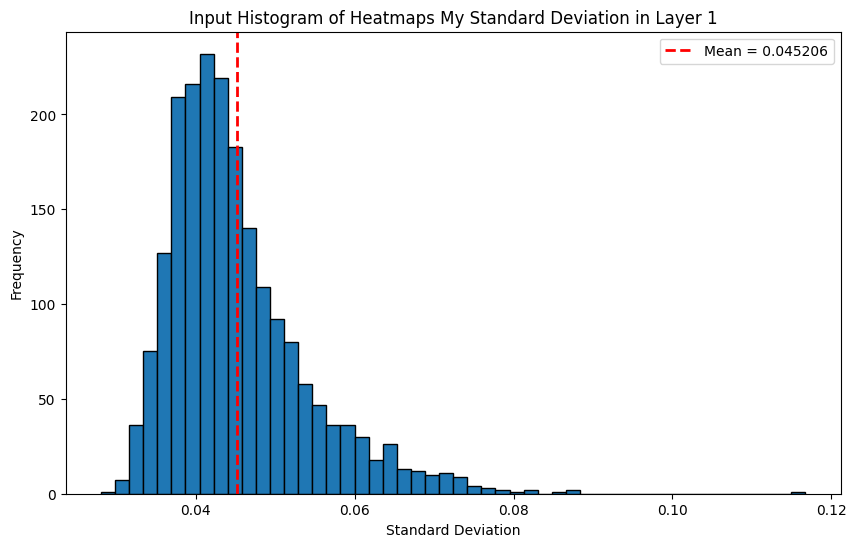

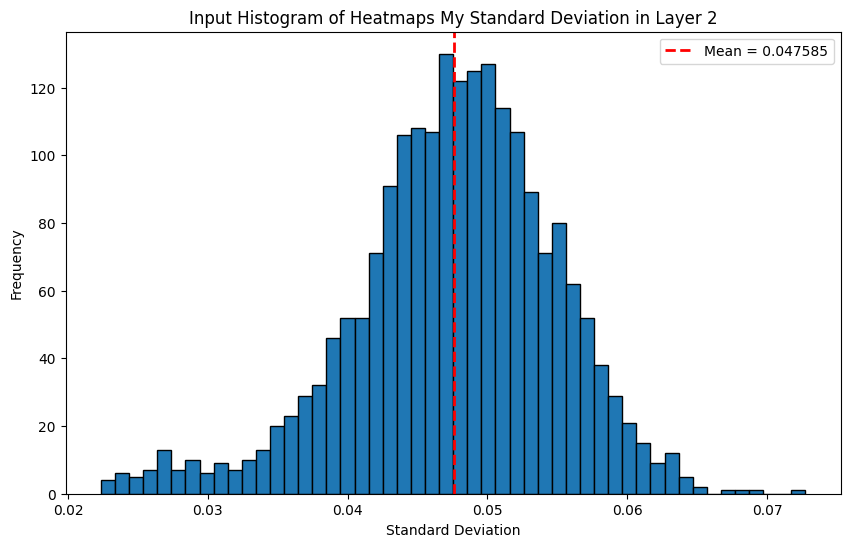

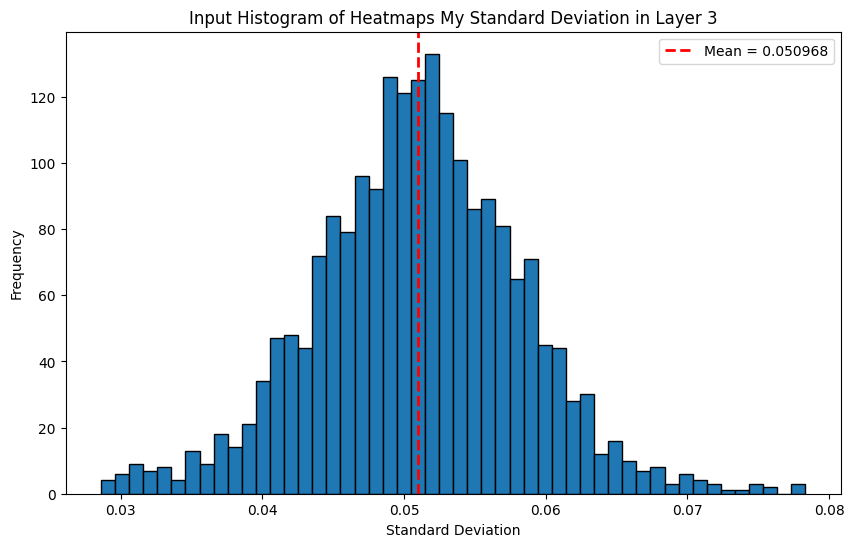

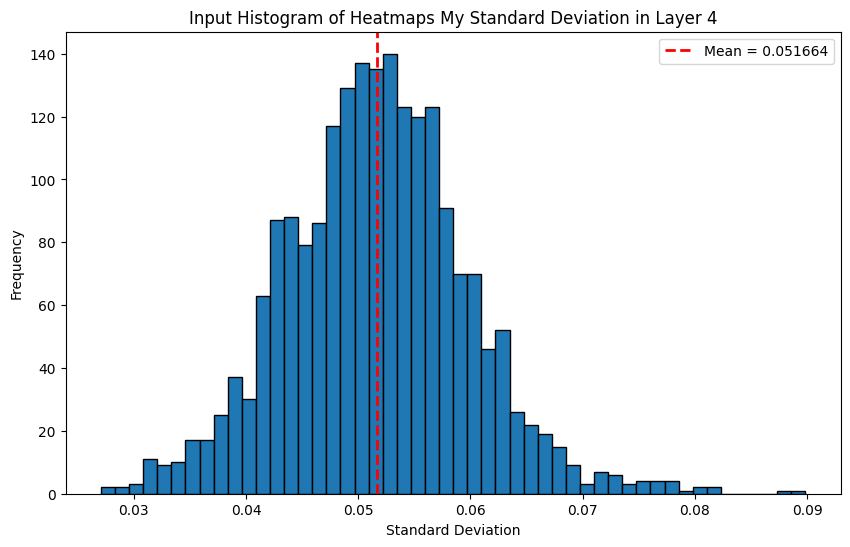

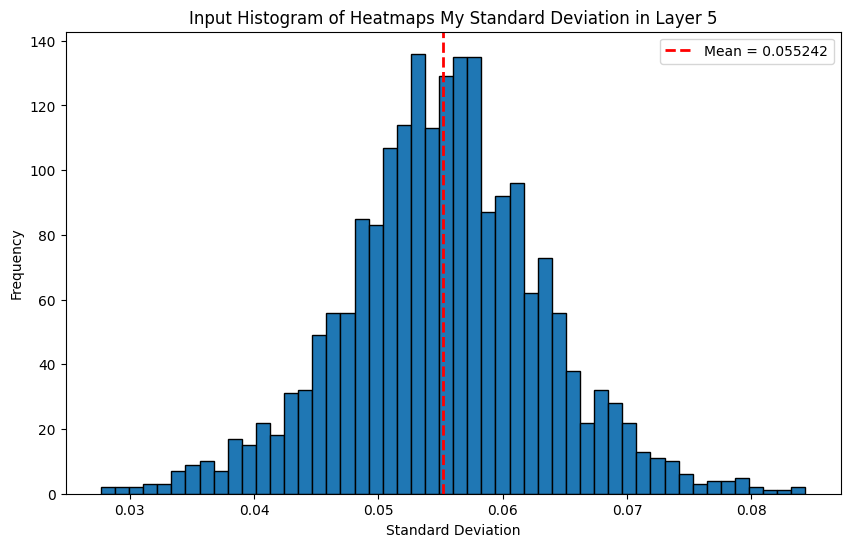

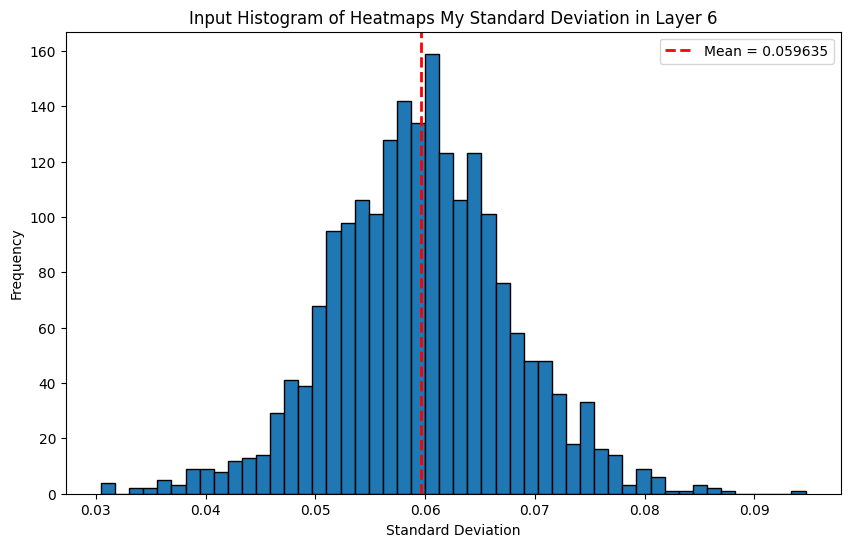

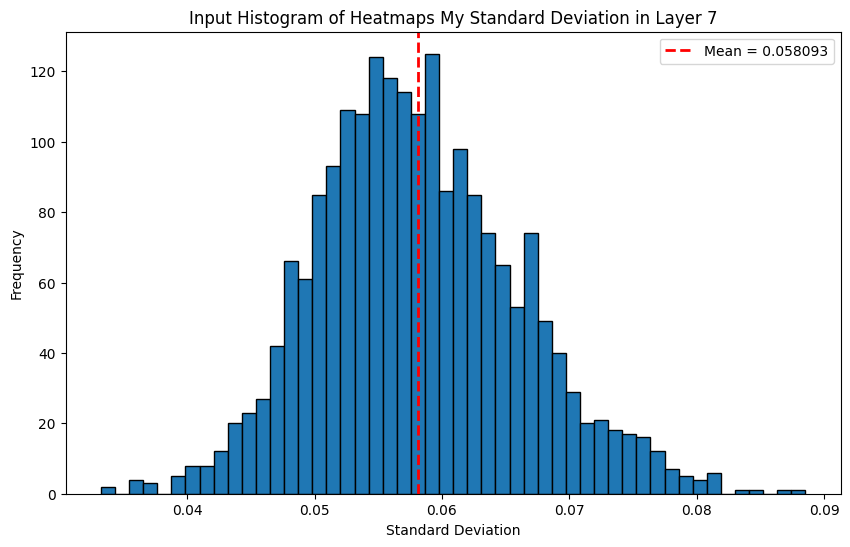

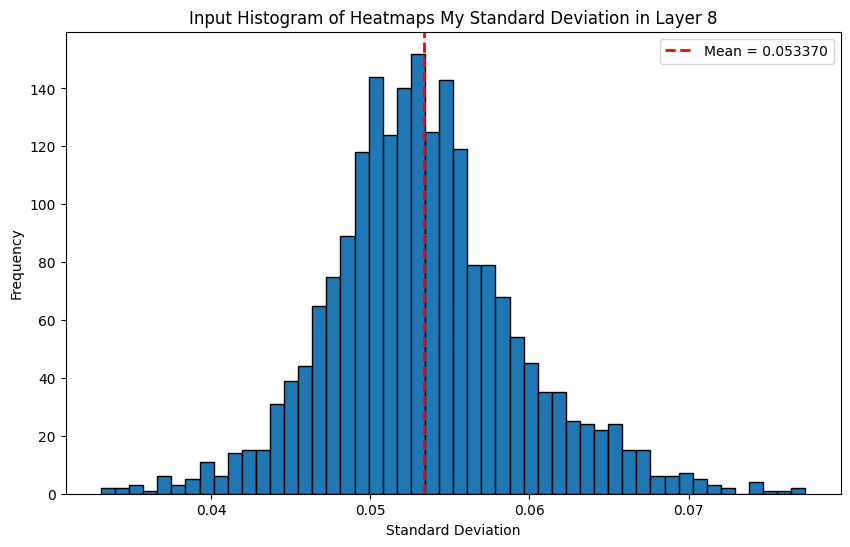

In [ ]:
layers = list(range(0,8))
mode = 2 # ["empty", "own", "enemy"]

for layer in layers:
    # Probe
    probe_path = f"probes/probe_layer_{layer}.pkl"
    full_linear_probe = torch.load(probe_path)
    my_probe_W = full_linear_probe.state_dict()[f'classifier.{mode}.weight'] # (64, 512)
    my_probe_W = my_probe_W.t()
    my_probe_normalised = my_probe_W / my_probe_W.norm(dim=0, keepdim=True) # torch.Size([512, 64])
    my_probe_normalised[:, [27, 28, 35, 36]] = 0.
    # Weight
    weight_in_key = f"blocks.{layer}.mlp_sublayer.proj.weight"
    
    heatmaps_my = []
    w_in = othello_gpt.state_dict()[weight_in_key] # torch.Size([512, 2048])
    w_in /= w_in.norm(dim=0, keepdim=True)
    for neuron in range(0, 2048):
        neuron_weight = w_in[:, neuron]
        heatmaps_my.append((neuron_weight[:, None] * my_probe_normalised).sum(dim=0))
        
    heatmaps_my = torch.stack(heatmaps_my).reshape(-1, 8, 8)
    
    if False:
        heatmaps_blank_std = heatmaps_blank.std(dim=[1, 2])
        mean_value = heatmaps_blank_std.mean().item()

        plt.figure(figsize=(10, 6))
        plt.hist(heatmaps_blank_std.detach().cpu().numpy(), bins=50, edgecolor='black')
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.4f}')
        plt.title(f"Input Histogram of Heatmaps Blank Standard Deviation in Layer {layer+1}")
        plt.xlabel("Standard Deviation")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
    else:
        heatmaps_my_std = heatmaps_my.std(dim=[1, 2])
        mean_value = heatmaps_my_std.mean().item()
        plt.figure(figsize=(10, 6))
        plt.hist(heatmaps_my_std.detach().cpu().numpy(), bins=50, edgecolor='black')
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_value:.6f}')
        plt.title(f"Input Histogram of Heatmaps My Standard Deviation in Layer {layer+1}")
        plt.xlabel("Standard Deviation")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()